<a href="https://colab.research.google.com/github/AntNeedsHelp/ExplainableAI/blob/main/CNN_pneumoniaMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu117
!pip3 install medmnist

Looking in indexes: https://download.pytorch.org/whl/cu117


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import datasets
import torch.utils.data as data


from tqdm import tqdm


import medmnist
from medmnist import INFO, Evaluator

In [ ]:
print(torch.__version__)

2.1.0+cu118


In [ ]:
data_flag = 'pneumoniamnist'
# data_flag = 'breastmnist'
download = True

NUM_EPOCHS = 3
BATCH_SIZE = 4
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [ ]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
trainloader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
testloader = data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)


classes = [
    "Negative",
    "Positive",
]


for X, y in testloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    print(f"y: {y}")
    break

Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Shape of X [N, C, H, W]: torch.Size([4, 1, 28, 28])
Shape of y: torch.Size([4, 1]) torch.int64
y: tensor([[1],
        [0],
        [1],
        [0]])


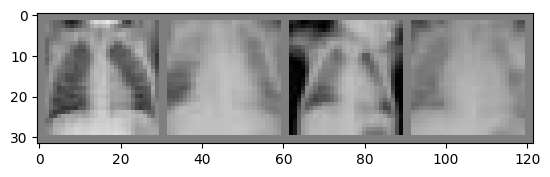

Negative Positive Positive Positive


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(BATCH_SIZE)))

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Define model
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(256, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = Net().to(device)


Using cuda device


In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [ ]:
def train(dataloader, model, loss_fn, optimizer, print_size=1):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        y = torch.squeeze(y)
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % print_size == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            y = torch.squeeze(y)
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.5f}%, Avg loss: {test_loss:>8f} \n")

ACTUAL TRAINING LOOP

In [ ]:
epochs = 10

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(trainloader, model, loss_fn, optimizer, 1000)
    test(testloader, model, loss_fn)
print("Done!")
%time

Epoch 1
-------------------------------
loss: 0.735056  [    4/ 4708]
loss: 0.605468  [ 4004/ 4708]
Test Error: 
 Accuracy: 62.50000%, Avg loss: 0.660711 

Epoch 2
-------------------------------
loss: 0.602546  [    4/ 4708]
loss: 0.572698  [ 4004/ 4708]
Test Error: 
 Accuracy: 62.50000%, Avg loss: 0.668557 

Epoch 3
-------------------------------
loss: 0.360479  [    4/ 4708]
loss: 0.341650  [ 4004/ 4708]
Test Error: 
 Accuracy: 62.50000%, Avg loss: 0.678911 

Epoch 4
-------------------------------
loss: 0.547802  [    4/ 4708]
loss: 1.036308  [ 4004/ 4708]
Test Error: 
 Accuracy: 62.50000%, Avg loss: 0.676769 

Epoch 5
-------------------------------
loss: 0.531724  [    4/ 4708]
loss: 0.579298  [ 4004/ 4708]
Test Error: 
 Accuracy: 62.50000%, Avg loss: 0.650057 

Epoch 6
-------------------------------
loss: 0.291926  [    4/ 4708]
loss: 1.121845  [ 4004/ 4708]
Test Error: 
 Accuracy: 62.50000%, Avg loss: 0.577875 

Epoch 7
-------------------------------
loss: 0.362898  [    4/ 

In [ ]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [ ]:
import os

os.getcwd()

'/content'

In [ ]:
model = Net().to(device)
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

In [ ]:
def normalize(pred):
  pred = np.log(np.exp(pred)/np.sum(np.exp(pred)))
  return pred

In [ ]:
classes = [
    0, #negative
    1, #positive
]

model.eval()
index = 1
x, y = test_dataset[index][0], test_dataset[index][1]
print("TD",x.shape)

print("max",np.max(x.numpy()))
print("min",np.min(x.numpy()))


x[0, 13, 13] = 0
print(x[0][13][13])

def get_pred(x):
  with torch.no_grad():
      x = x.to(device)
      pred = normalize(model(x[None]).cpu().numpy())

      #normalize pred ^^^^

      print("PRED:",pred)
      predicted, actual = classes[pred[0].argmax(0)], classes[y[0]]
      print(f'Predicted: "{predicted}", Actual: "{actual}"')

  return pred, (predicted, actual)

pred_array = np.zeros((x.shape[1], x.shape[2], 2))
bool_array = np.zeros((x.shape[1], x.shape[2],2))

for i in range(x.shape[1]):
  for j in range(x.shape[2]):
    orig_value = x[0,i:i+2,j:j+2].clone().detach()
    x[0,i:i+2,j:j+2] = 0
    pred_array[i,j,:], bool_array[i,j,:] = get_pred(x)
    #print(get_pred(x))
    x[0,i:i+2,j:j+2] = orig_value

TD torch.Size([1, 28, 28])
max 0.6627451
min -0.42745095
tensor(0.)
PRED: [[-4.272009   -0.01405201]]
Predicted: "1", Actual: "0"
PRED: [[-4.271393   -0.01406072]]
Predicted: "1", Actual: "0"
PRED: [[-4.2703285  -0.01407577]]
Predicted: "1", Actual: "0"
PRED: [[-4.2700577  -0.01407964]]
Predicted: "1", Actual: "0"
PRED: [[-4.27869    -0.01395778]]
Predicted: "1", Actual: "0"
PRED: [[-4.2751484  -0.01400765]]
Predicted: "1", Actual: "0"
PRED: [[-4.285589   -0.01386114]]
Predicted: "1", Actual: "0"
PRED: [[-4.2930226 -0.0137578]]
Predicted: "1", Actual: "0"
PRED: [[-4.2957506  -0.01372003]]
Predicted: "1", Actual: "0"
PRED: [[-4.283362   -0.01389226]]
Predicted: "1", Actual: "0"
PRED: [[-4.2862854  -0.01385141]]
Predicted: "1", Actual: "0"
PRED: [[-4.2748013  -0.01401254]]
Predicted: "1", Actual: "0"
PRED: [[-4.275515   -0.01400251]]
Predicted: "1", Actual: "0"
PRED: [[-4.273629  -0.0140291]]
Predicted: "1", Actual: "0"
PRED: [[-4.274282   -0.01401986]]
Predicted: "1", Actual: "0"
PRED: 

In [ ]:
for X, y in testloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    print(f"Value of y {y}")

Shape of X [N, C, H, W]: torch.Size([4, 1, 28, 28])
Shape of y: torch.Size([4, 1]) torch.int64
Value of y tensor([[1],
        [0],
        [1],
        [0]])
Shape of X [N, C, H, W]: torch.Size([4, 1, 28, 28])
Shape of y: torch.Size([4, 1]) torch.int64
Value of y tensor([[1],
        [1],
        [1],
        [1]])
Shape of X [N, C, H, W]: torch.Size([4, 1, 28, 28])
Shape of y: torch.Size([4, 1]) torch.int64
Value of y tensor([[1],
        [0],
        [1],
        [1]])
Shape of X [N, C, H, W]: torch.Size([4, 1, 28, 28])
Shape of y: torch.Size([4, 1]) torch.int64
Value of y tensor([[1],
        [1],
        [1],
        [1]])
Shape of X [N, C, H, W]: torch.Size([4, 1, 28, 28])
Shape of y: torch.Size([4, 1]) torch.int64
Value of y tensor([[1],
        [1],
        [1],
        [0]])
Shape of X [N, C, H, W]: torch.Size([4, 1, 28, 28])
Shape of y: torch.Size([4, 1]) torch.int64
Value of y tensor([[0],
        [1],
        [1],
        [1]])
Shape of X [N, C, H, W]: torch.Size([4, 1, 28,